# Logical Error Rate Evaluation (rotated surface code)

In [1]:
# This cell is tagged `parameters` and will be override by `papermill`
# all `=` should be replaced by `@` in the string, otherwise papermill won't be able to parse them
decoder_eval: str = '"mwpm"'
code_eval: str = 'f"rsc(d@{c.d},p@{p})"'
noise_eval: str = '"none"'
config_vec_eval: str = '[dmap(d@3), dmap(d@5), dmap(d@7), dmap(d@9), dmap(d@11)]'

p_center: float = 0.01  # this p value is choosen such that the logical error rate is not too high or too low
per10_p_count: int = 3  # how many p to take per x10 interval

slurm_maximum_jobs = 100
slurm_cores_per_node: int = 10  # (slurm_maximum_jobs // slurm_cores_per_node) should not exceed 200
slurm_mem_per_job: int = 2  # 2GB per job
slurm_walltime: str = "1-00:00:00"  # 11 hours (adaptively shutdown if no more jobs)
slurm_partition: str = "scavenge"

local_maximum_jobs = 10

json_filename: str | None = None
mark_finished: bool = False  # only plot the figure and do not run experiments
shudown_cluster: bool | None = None  # by default shutdown on cluster and do not shutdown on local machine

In [2]:
# Parameters
code_eval = "f\"usc(d@{c.d},p@{p})\""
noise_eval = "\"none\""
p_center = 0.01
config_vec_eval = "[dmap(d@3),dmap(d@5),dmap(d@7),dmap(d@9),dmap(d@11)]"
slurm_maximum_jobs = 30
decoder_eval = "\"mwpm\""


In [3]:
# to get around papermill limitation: there cannot be = character in the string
decoder_eval = decoder_eval.replace("@", "=")
code_eval = code_eval.replace("@", "=")
noise_eval = noise_eval.replace("@", "=")
config_vec_eval = config_vec_eval.replace("@", "=")

In [4]:
from slugify import slugify
from dotmap import DotMap as dmap

config_vec = eval(config_vec_eval)
print(config_vec)

if json_filename is None:
    json_filename = slugify(code_eval) + "." + slugify(noise_eval) + "." + slugify(decoder_eval) + ".json"
print(json_filename)

[DotMap(d=3), DotMap(d=5), DotMap(d=7), DotMap(d=9), DotMap(d=11)]
f-usc-d-c-d-p-p.none.mwpm.json


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from qec_lego_bench.hpc.monte_carlo import *
from qec_lego_bench.hpc.submitter import *
from qec_lego_bench.hpc.plotter import *
from typing import Iterable
from qec_lego_bench.cli.logical_error_rate import logical_error_rate

### Define the job list

In [7]:
ap_vec = AdaptivePVec(p_center=p_center, per10_p_count=per10_p_count)
jobs = [MonteCarloJob(config=config, p=p_center) for config in config_vec]


def monte_carlo_function(
    shots: int, config: dmap, p: float
) -> tuple[int, LogicalErrorResult]:
    c = config
    decoder = eval(decoder_eval)
    code = eval(code_eval)
    noise = eval(noise_eval)
    stats = logical_error_rate(
        decoder=decoder,
        code=code,
        noise=noise,
        max_shots=shots,
        max_errors=shots,
        no_progress=True,
        no_print=True,
    )
    return stats.shots, LogicalErrorResult(errors=stats.errors, discards=stats.discards)


monte_carlo_function(1000, config_vec[0], p_center)

(1000, LogicalErrorResult(errors=76, discards=0))

### Define the strategy to submit jobs

In [8]:
adaptive_submitter = AdaptivePVecSubmitter(
    config_vec=config_vec,
    ap_vec=ap_vec,
    time_limit=3600,
    min_shots=1000,
    target_precision=0.1,
)
precision_submitter = PrecisionSubmitter(
    time_limit=100 * 3600, min_precision=1, target_precision=0.03
)


def submitter(executor: MonteCarloJobExecutor) -> list[tuple[MonteCarloJob, int]]:
    submit = adaptive_submitter(executor)
    if len(submit) == 0 and executor.no_pending():  # previous submitter all finished
        submit += precision_submitter(executor)
    return submit

## The rest of the notebook runs the evaluation

Start a cluster by intelligently choose Slurm or Local cluster.

In [9]:
if not mark_finished:
    try:
        from dask_jobqueue import SLURMCluster
        from dask.distributed import Client
        n_workers = slurm_maximum_jobs // slurm_cores_per_node
        assert n_workers <= 200, "Yale HPC forbids submitting more than 200 jobs per hour"
        slurm_job_folder = os.path.join(os.path.abspath(os.getcwd()), "slurm_job")
        cluster = SLURMCluster(
            queue=slurm_partition,
            cores=slurm_cores_per_node,
            processes=slurm_cores_per_node,
            memory=f"{slurm_mem_per_job * slurm_cores_per_node} GB",
            walltime=slurm_walltime,
            job_extra_directives=[f'--out="{slurm_job_folder}/%j.out"', f'--error="{slurm_job_folder}/%j.err"'],
        )
        print(cluster.job_script())
        # cluster.scale(slurm_maximum_jobs)
        cluster.adapt(minimum=slurm_maximum_jobs, maximum=slurm_maximum_jobs)  # allow respawn
        if shudown_cluster is None:
            shudown_cluster = True
    except Exception as e:
        print(e)
        from dask.distributed import Client, LocalCluster
        cluster = LocalCluster(n_workers=local_maximum_jobs)
        if shudown_cluster is None:
            shudown_cluster = False
    print(cluster.dashboard_link)
    cluster

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p scavenge
#SBATCH -n 1
#SBATCH --cpus-per-task=10
#SBATCH --mem=19G
#SBATCH -t 1-00:00:00
#SBATCH --out="/gpfs/gibbs/project/lin_zhong/yw729/qec-lego-bench/docs/notebooks/evaluation/logical-error-rate/f-usc-d-c-d-p-p_none/slurm_job/%j.out"
#SBATCH --error="/gpfs/gibbs/project/lin_zhong/yw729/qec-lego-bench/docs/notebooks/evaluation/logical-error-rate/f-usc-d-c-d-p-p_none/slurm_job/%j.err"

/home/yw729/.conda/envs/qec/bin/python -m distributed.cli.dask_worker tcp://10.181.173.28:39927 --name dummy-name --nthreads 1 --memory-limit 1.86GiB --nworkers 10 --nanny --death-timeout 60

http://10.181.173.28:43467/status


/home/yw729/.conda/envs/qec/lib/python3.10/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43467 instead
  warnings.warn(


In [10]:
config = MonteCarloExecutorConfig()
config.max_submitted_job = max(config.max_submitted_job, 3 * slurm_maximum_jobs)
executor = MonteCarloJobExecutor(
    monte_carlo_function,
    jobs,
    config=config,
    filename=json_filename,
)

### Define the callback, e.g. plotting the intermediate result and the list of remaining tasks

(I have to put them in the same block as the actual execution, otherwise it won't update in VScode)

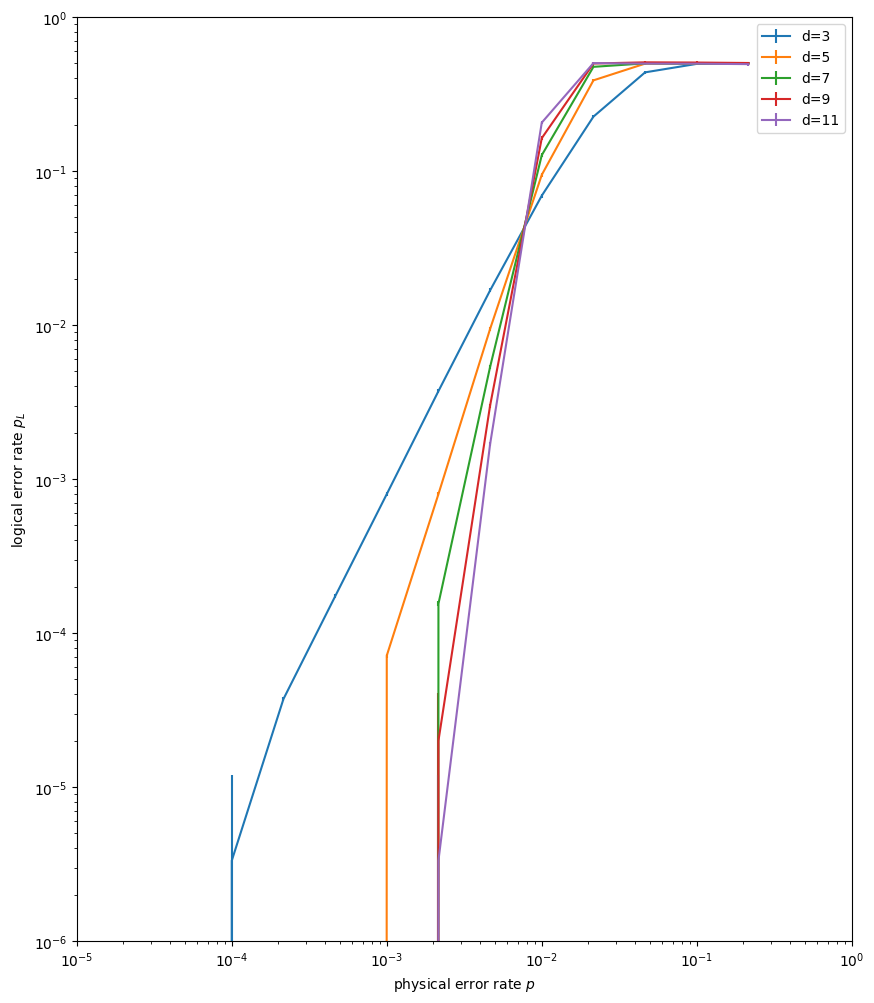

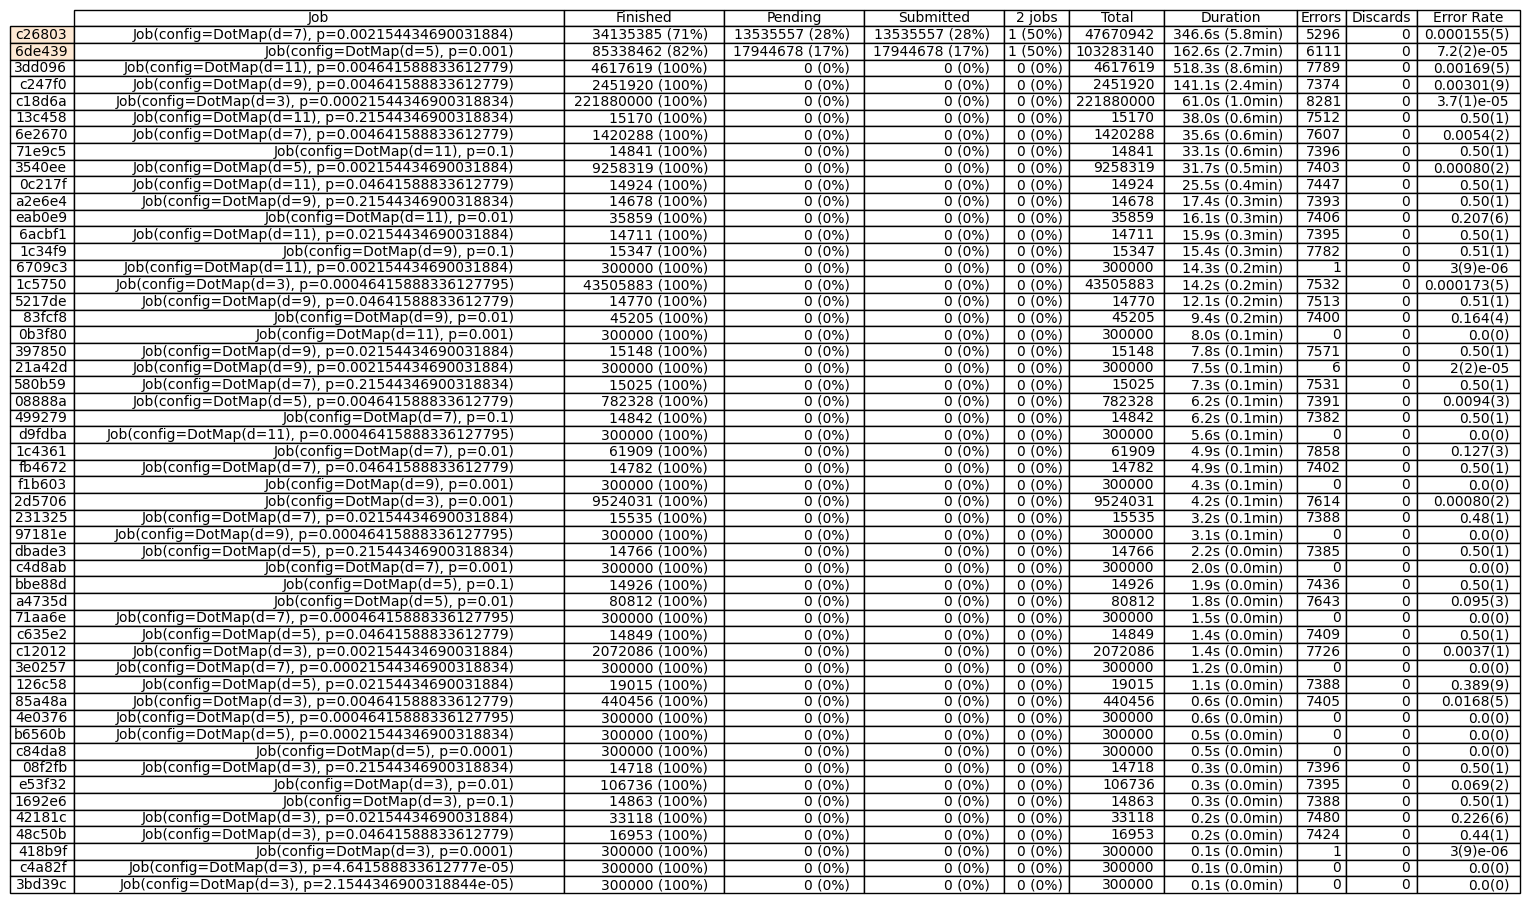

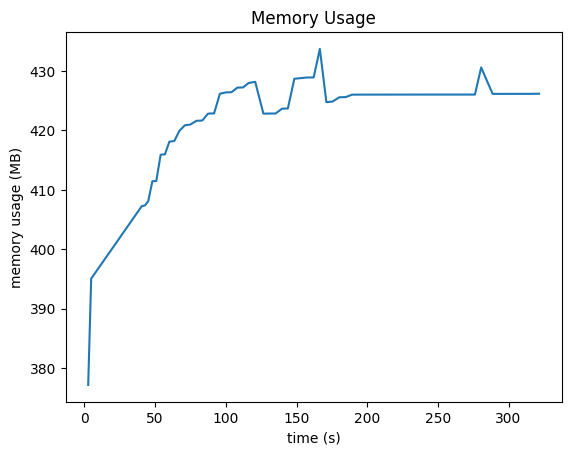

will shut down the cluster after job finishes; if this is not desired, set `shudown_cluster` to False


In [11]:
plotter = AdaptivePVecPlotter(config_vec=config_vec, ap_vec=ap_vec)
progress_plotter = JobProgressPlotter()
memory_plotter = MemoryUsagePlotter()


def callback(executor: MonteCarloJobExecutor):
    plotter(executor)
    progress_plotter(executor)
    memory_plotter(executor)


if mark_finished:
    executor.execute(None, submitter, loop_callback=callback)
else:
    if shudown_cluster:
        print(
            "will shut down the cluster after job finishes; if this is not desired, set `shudown_cluster` to False"
        )
    with Client(cluster) as client:
        try:
            executor.execute(client, submitter, loop_callback=callback)
        finally:
            if shudown_cluster:
                print(
                    "shutting down the whole cluster; if this is not desired, set `shudown_cluster` to False"
                )
                client.shutdown()